<a href="https://colab.research.google.com/github/s1c5000/tensorflow2.0/blob/main/%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오터인코더

지금까지 살펴본 네트워크들은 입력(x)에 대한 출력(y)를 학습한 뒤에 학습과정에서 못봤던 새로운 입력에 대해서도 알맞은 정답을 출력하는 것이 목표였다. 이러한 방법을 지도학습이라고 한다.     
오토인코더는 입력에 대한 출력을 학습해야한다는 점은같지만 그 출력이 입력과 동일하다는 점이 특이하다

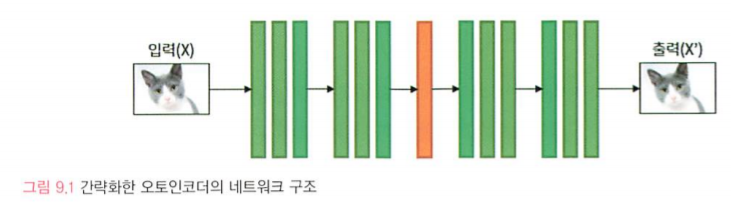

즉 오토인코더는 자기 자신을 재생성하는 네트워크이다. 이미 입력데이터를 가지고 있는데 왜 자기자신을 재 생성 할까?

## 9.1 인코더와 디코더, 잠재변수

오토인코더는 크게 세부분으로 나눌 수 있다. 가운데 주황색의 Dense 레이어로 표시되는 잠재 변수(Latent Vector)를 중심으로 입력에 가까운부분을 인코더(Encoder), 출력에 가까운 부분을 디코더(Decoder)로 분류 할 수 있다.

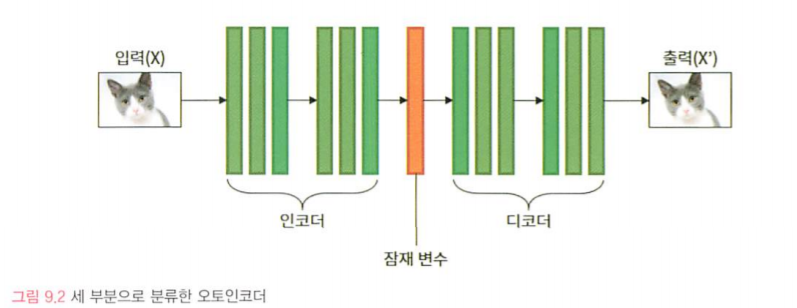

인코더는 입력에서 잠재 변수를 만드는 부분이고, 디코더는 잠재 변수를 출력으로 만드는 부분이다. 그림 9.2 에서 알 수 있듯이 둘은 일반적으로 동일한 레이어를 대칭되는 구조로 쌓아올려서 만든다.      
인코더는 지금까지 컨볼루션에서 봐왔던 특징추출기와 같은 역할을 한다. 특징 추출기는 입력이미지에서 특징을 추출해서 일차원의 벡터로 만들었다. 이 일차원의 벡터가 바로 잠재변수이다.      
잠재변수에는 입력데이터가 압축돼 있다. 이 압축된 데이터를 다시 해석해서 출력 데이터 즉 동일한 입력데이터로 만들어주는 것이 디코더의 역할이다.      
오토인코더는 운영체제에서 자주 사용하는 파일 압축과도 비교할 수 있다. 바로 비손실 압축이다.       
이와 달리 오토인코더는 손실 압축으로 입력과 출력이 완전히 일치하지는 않다. 대신 압축률이 비손실 압축보다 크게 올라가며, 압축률을 높이는 과정에서 잠재 변수에 원본 데이터의 특징을 잘 나타내는 효율적인 방법을 찾게된다. 더 적은 양의 데이터로 많은 양의 정보를 표현해야 하기 때문이다



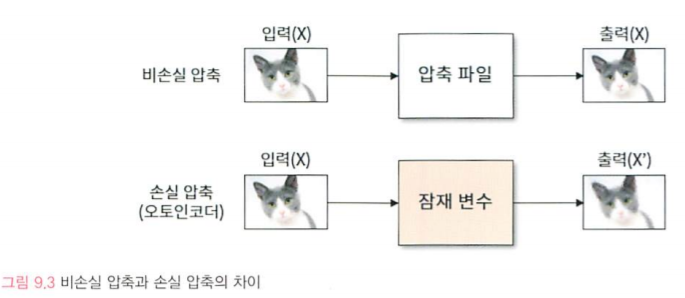

이렇게 압축된 잠재 변수는 데이터의 특징을 가장 잘 표현하는 정보이기 때뭉에 여러가지 용도로 쓰인다. 오토인코더에서는 잠재 변수를 입력으로 삼아 디코더를 통해 이미지등을 생성한다. 클러스터링에서도 잠재변수를 사용하는 예제를 확인할 수 있다. 딥러닝 생성 모델 중 최근 주목받고있는 적대적생성모델(Generative Adversarial Network, GAN)의 생성자(Generator)에서는 랜덤하게 생성된 변수를 잠재변수처럼 활용해서 새로운 이미지를 얻는다

## 9.2 mnist 데이터세트에 적용하기

고차원의 데이터를 저차원의 벡터로 압축하는 인코더는 6장 컨볼루션 신경망 부터 많이 다뤘지만 디코더는 처음 다루는 내용이다 이해를 위해 mnist로 실습을 해보겠다.     

In [ ]:
# 텐서플로 2 버전 선택
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
import numpy as np

# 9.1 MNIST 데이터세트 불러오기
(train_X, train_Y), (test_X, test_Y) = tf.keras.datasets.mnist.load_data()
print(train_X.shape, train_Y.shape)

train_X = train_X / 255.0
test_X = test_X / 255.0

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)


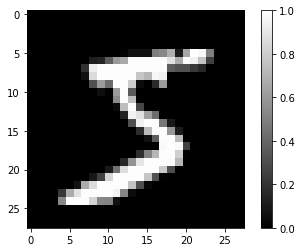

5


In [ ]:
# 9.2 MNIST 데이터세트 확인
import matplotlib.pyplot as plt
plt.imshow(train_X[0].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

print(train_Y[0])

가장 간단한 형태의 오토인코더를 만들어보겠다. 5장에서는 Fashion mnist를 분류할때 Dense 레이어를 사용했고, 6장에서는 컨볼루션 레이어를 사용했다. 여기서도 먼저 Dense레이어를 사용한 모델을 학습시켜본 후 컨볼루션 레이어를 사용해 보겠다

In [ ]:
# 9.3 Dense 오토인코더 모델 정의
train_X = train_X.reshape(-1, 28 * 28)
test_X = test_X.reshape(-1, 28 * 28)
print(train_X.shape, train_Y.shape)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(784, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(784, activation='sigmoid')
])

model.compile(optimizer=tf.optimizers.Adam(), loss='mse')
model.summary()

(60000, 784) (60000,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 784)               615440    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               50960     
Total params: 716,640
Trainable params: 716,640
Non-trainable params: 0
_________________________________________________________________


모델을 정의하기 전에 입력 데이터를 처리하기 위해 Flatten레이어를 사용하는 대신 train_X와 test_X의 차원을 직접 reshape()함수로 변환했다. 그 이유는 입력과 출력의 형태가 같아야 하기 때문이다. 입력을 변환하지 않은 채로 앞에 Flatten레이어를 넣어서 (28, 28) 차원의 입력을 넣으면 뒤에서도 출력의 차원을 다시( 28, 28)로 맞추기위해 Reshape레이어를 사용해야 할 것이다. 그런 불편을 없애기 위해 데이터의 차원을 직접 변환한 다음에 사용해 간결하게 만들었다.      
네트워크의 첫번째 Dense 레이어와 세번째 Dense레이어는 뉴런의 수가 같아서 대칭을 이룬다. 이 둘은 각각 인코더와 디코더의 역할을 한다.      
두번째 레이어는 첫번째와 세번째보다 뉴런의 수가 꽤 적다. 오토인코더의 가운데에 있는 이 레이어가 잠재변수를 만드는 레이어이고, 이 레이어의 출력이 입력의 잠재변수가 된다.

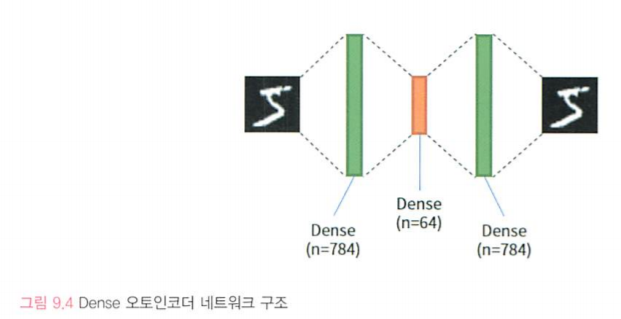

In [ ]:
# 9.4 Dense 오토인코더 모델 학습
model.fit(train_X, train_X, epochs=10, batch_size=256)

Epoch 1/10
235/235 [==============================] - 1s 4ms/step - loss: 0.0514
Epoch 2/10
235/235 [==============================] - 1s 4ms/step - loss: 0.0171
Epoch 3/10
235/235 [==============================] - 1s 4ms/step - loss: 0.0120
Epoch 4/10
235/235 [==============================] - 1s 4ms/step - loss: 0.0099
Epoch 5/10
235/235 [==============================] - 1s 4ms/step - loss: 0.0087
Epoch 6/10
235/235 [==============================] - 1s 4ms/step - loss: 0.0080
Epoch 7/10
235/235 [==============================] - 1s 4ms/step - loss: 0.0074
Epoch 8/10
235/235 [==============================] - 1s 4ms/step - loss: 0.0070
Epoch 9/10
235/235 [==============================] - 1s 4ms/step - loss: 0.0067
Epoch 10/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0065


모델의 입력과 출력에 해당하는 부분에 모두 train_X를 넣어서 입력에 대해 동일한 출력을 얻을 수 있게 한다. 데이터 하나 하나의 크기가 비교적 작기 때문에 빠른 학습을 위해 batch_size에 큰 숫자를 넣었다.      
학습이 잘 됐는지 판단할 수 있는 유일한 척도인 loss는 0.0049인데 이 수만 봐서는 입력을 어느정도로 재 생성 할 수 있는 것인지 파악이 힘들다.       
학습과정에서 주어지지않았던 테스트 데이터를 오토인코더에 넣었을 때 입력 이미지가 잘 재생성되는지 확인해 보겠다. 그리고 model.evaluate()함수로 테스트데이터에 대한 loss가 어느정도로 나오는지도 알아보겠다

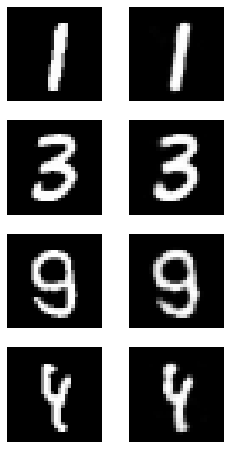

313/313 [==============================] - 1s 2ms/step - loss: 0.0062


0.006247342564165592

In [ ]:

# 9.5 test 데이터로 Dense 오토인코더의 이미지 재생성
import random

plt.figure(figsize=(4,8))
for c in range(4):
    plt.subplot(4, 2, c*2+1)
    rand_index = random.randint(0, test_X.shape[0])
    plt.imshow(test_X[rand_index].reshape(28, 28), cmap='gray')
    plt.axis('off')
    
    plt.subplot(4, 2, c*2+2)
    img = model.predict(np.expand_dims(test_X[rand_index], axis=0))
    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.axis('off')
    
plt.show()

model.evaluate(test_X, test_X)

결과 이미지에서 왼쪽이 입력, 오른쪽이 재생성된 출력이다. 테스트 데이터 중 랜덤한 네 개에 대한 이미지 재생성 결과를 확인해보면 대체로 입력과 매우 비슷한 결과를 만들어 내지만 일부분은 좀더 흐릿해지거나 윤곽선이 달라지는 것을 볼 수 있다. evaluate()함수로 평가한 loss는 0.0048로 훈련데이터와 거의 비슷하게 나온다        


컨볼루션 신경망을 써보면 더 결과가 잘 나올까?
먼저 컨볼루션 레이어를 2개 사용한 모델을 정의해 보겠다

In [ ]:
# 9.6 컨볼루션 오토인코더 모델 정의
train_X = train_X.reshape(-1, 28, 28, 1)
test_X = test_X.reshape(-1, 28, 28, 1)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, strides=(2,2), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, strides=(2,2), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(7*7*64, activation='relu'),
    tf.keras.layers.Reshape(target_shape=(7,7,64)),
    tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=(2,2), padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=2, strides=(2,2), padding='same', activation='sigmoid')
])

model.compile(optimizer=tf.optimizers.Adam(), loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          8256      
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                200768    
_________________________________________________________________
dense_4 (Dense)              (None, 3136)              203840    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 32)       

먼저 모델을 정의하기 전 컨볼루션 레이어를 사용하기 위해 데이터에 reshpae()함수를 사용해서 컬러 차원을 더해준다. 흑백 이미지 이기때문에 마지막 차원의 수는 1이다     
그 다음 컨볼루션 레이어 2개를 쌓는다      
그런데 여기는 컨볼루션 레이어와 함께 쓰이는 풀링 레이어가 빠져 있다. 대신 kernel_size =2, strides = (2,2)로 설정해서 풀링 레이어를 쓰는 것과 같은 효과를 준다. 한번에 보는 영역은 (2,2) 픽셀이고 건너뛰는 너비와 높이도 (2,2) 이기때문에 이미지가 절반으로 줄어든다.

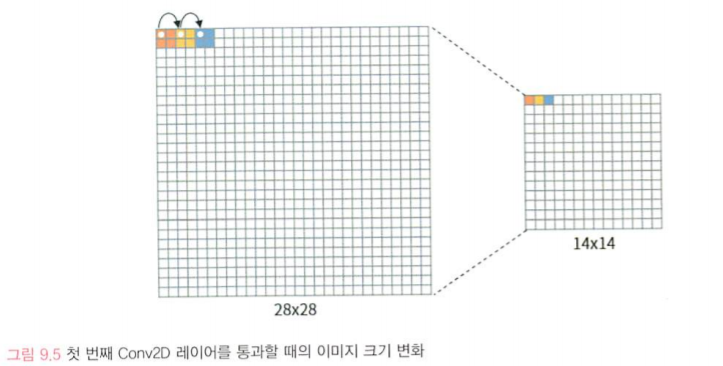

두번쩨 컨볼루션레이어를 통과하면 이미지의 크기는 7 * 7 크기가 된다. 

그 다음 잠재 변수를 만들기위해 Dense 오토인코더와 동일한 크기로 64개의 뉴런을 가지는 Dense레이어를 배치한다. 물론 그 전에 3차원의 데이터를 1차원으로 바꿔주기 위해 Flatten 레이어를 통과해야 한다.     
tf.keras.layers.Flatten(),      

tf.keras.layers.Dense(64, activation='relu'),      

잠재변수를 만든 다음에는 디코더를 만든다 . 디코더는 인코더와 대칭이 되도록 쌓아올린다. 잠재 변수 레이어와 연결된 레이어는 7 * 7 이미지를 64개의 채널만큼 가지고 있는 컨볼루션 레이어였다. 그 레이어와 뉴런 수를 동일하게 만들기 위해 먼저 Dense레이어의 뉴런 수를 7 * 7 * 64로 넣는다.      
tf.keras.layers.Dense(7*7*64, activation='relu'),

그 다음에는 Dense 레이어의 모양대로 1차원인 데이터를 3차원으로 바꿔주기 위해, 즉 7 * 7 이미지를 64개의 채널만큼 갖도록 Reshape 레이어를 사용한다.      
마지막으로 이어지는 2개의 레이어는 Conv2DTranspose이다. 이름처럼 Conv2D레이어가 하는일의 반대 되는 계산, 즉 입력이 되는 하나의 값을 컨볼루션에 통과시켜 출력의 여러값을 계산해주는 레이어이다. 하는일이 천볼루션의 반대이기때문에 디컨볼루션 레이어라고도 부른다. 두번째 Conv2DTranspose레이어는 필터의 개수가 1로 흑백채널의 이미지와 채널수가 일치한다. 활성화함수로 sigmoid를 사용해 최종 출력값에는 0에서 1사이인 컬러값이 나오게 했다.

model.summary()를 보면 총 파라미터수는 42만개로 Dense 오토인코더의 71만개보다 적다.

In [ ]:
model.fit(train_X, train_X, epochs=20, batch_size = 256)

Epoch 1/20
235/235 [==============================] - 2s 9ms/step - loss: 0.0796
Epoch 2/20
235/235 [==============================] - 2s 8ms/step - loss: 0.0299
Epoch 3/20
235/235 [==============================] - 2s 8ms/step - loss: 0.0203
Epoch 4/20
235/235 [==============================] - 2s 8ms/step - loss: 0.0180
Epoch 5/20
235/235 [==============================] - 2s 8ms/step - loss: 0.0170
Epoch 6/20
235/235 [==============================] - 2s 8ms/step - loss: 0.0164
Epoch 7/20
235/235 [==============================] - 2s 8ms/step - loss: 0.0160
Epoch 8/20
235/235 [==============================] - 2s 8ms/step - loss: 0.0157
Epoch 9/20
235/235 [==============================] - 2s 8ms/step - loss: 0.0155
Epoch 10/20
235/235 [==============================] - 2s 8ms/step - loss: 0.0153
Epoch 11/20
235/235 [==============================] - 2s 8ms/step - loss: 0.0152
Epoch 12/20
235/235 [==============================] - 2s 8ms/step - loss: 0.0151
Epoch 13/20
235/235 [====

Dense 오토인코더보다 2배인 20에포크를 훈련시켰지만 loss가 줄어드는 속도는 더 느리다. 테스트데이터의 이미지를 얼마나 잘 재현하는지 알아보겠다.

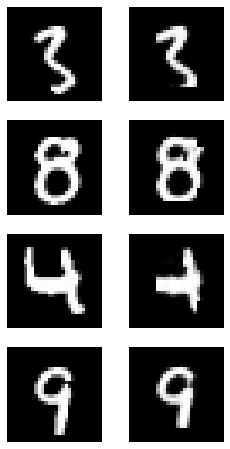

313/313 [==============================] - 1s 3ms/step - loss: 0.0141


0.014114960096776485

In [ ]:
# 9.8 test 데이터로 컨볼루션 오토인코더의 이미지 재생성
import random

plt.figure(figsize=(4,8))
for c in range(4):
    plt.subplot(4, 2, c*2+1)
    rand_index = random.randint(0, test_X.shape[0])
    plt.imshow(test_X[rand_index].reshape(28, 28), cmap='gray')
    plt.axis('off')
    
    plt.subplot(4, 2, c*2+2)
    img = model.predict(np.expand_dims(test_X[rand_index], axis=0))
    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.axis('off')
    
plt.show()

model.evaluate(test_X, test_X)

오른쪽의 출력 결과는 왼족의 원본에 비해 중간중간 각진 모습이 보인다. 이것은 네트워크의 일부분에서 값이 아예 사라지는 것을 의미한다. 마지막 레이어를 제외하면 활성화함수로는 relu를 사용했다. relu는 양수는 그대로 반환하고 0이나 음수가 들어오면 0을 반환한다. 뉴런의 계산값 중 음수가 되는 결과가 많을 경우 그 뉴런의 출력은 무조건 0이 된다.

출력은 다음 레이어의 가중치에 곱해지기 때문에 출력이 0이면 가중치의 효과를 모두 0으로 만들어버리게 된다. 물론 편향이 더해지겠지만 만약 편향이 0이나 음수라면 ReLU활성화 함수를 통과한 다음 레이어의 출력도 0이 된다

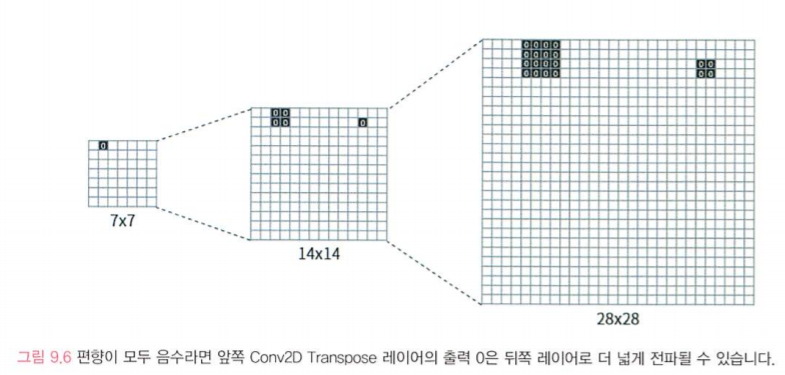

편향이 모두 음수라고 가정하면 출력값 0은 뒤쪽 레이어에 4배 16배의 영향을 준다. 위 사진의 각진 모습은 활성화함수 ReLU가 음수를 0으로 출력하는 이런 특성때문에 발생한 것이다.      
위와 같은 ReLU의 문제점을 해결하기 위해 ReLU와 비슷하지만 음수를 받았을 때 0보다 조금 작은 음수를 출력하는 여러 종류의 함수가 고안되었다. 그 중 ELU는 이렇게 계산된다

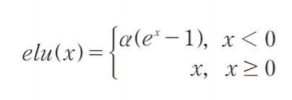         
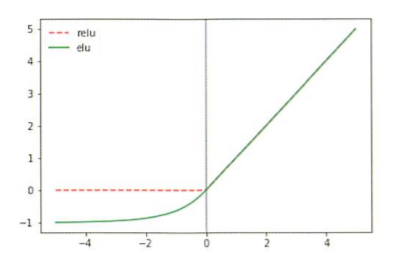

elu는 0 이하에서 부드럽게 감소하여 -1에 수렴한다. 이렇게 값이 약간 남아있는 경우 오토인코더의 학습 결과에 어떤 영향을 줄까?      
9.6모델의 활성화 함수만 elu로 바꿔서 학습시켜보겠다.

In [ ]:
# 9.9 활성화함수를 elu로 바꾼 컨볼루션 오토인코더 모델 정의 및 학습
train_X = train_X.reshape(-1, 28, 28, 1)
test_X = test_X.reshape(-1, 28, 28, 1)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, strides=(2,2), activation='elu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, strides=(2,2), activation='elu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='elu'),
    tf.keras.layers.Dense(7*7*64, activation='elu'),
    tf.keras.layers.Reshape(target_shape=(7,7,64)),
    tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=(2,2), padding='same', activation='elu'),
    tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=2, strides=(2,2), padding='same', activation='sigmoid')
])

model.compile(optimizer=tf.optimizers.Adam(), loss='mse')

model.fit(train_X, train_X, epochs=20, batch_size=256)

Epoch 1/20
235/235 [==============================] - 2s 9ms/step - loss: 0.0540
Epoch 2/20
235/235 [==============================] - 2s 9ms/step - loss: 0.0191
Epoch 3/20
235/235 [==============================] - 2s 8ms/step - loss: 0.0129
Epoch 4/20
235/235 [==============================] - 2s 9ms/step - loss: 0.0110
Epoch 5/20
235/235 [==============================] - 2s 9ms/step - loss: 0.0102
Epoch 6/20
235/235 [==============================] - 2s 9ms/step - loss: 0.0097
Epoch 7/20
235/235 [==============================] - 2s 9ms/step - loss: 0.0093
Epoch 8/20
235/235 [==============================] - 2s 9ms/step - loss: 0.0091
Epoch 9/20
235/235 [==============================] - 2s 9ms/step - loss: 0.0089
Epoch 10/20
235/235 [==============================] - 2s 9ms/step - loss: 0.0087
Epoch 11/20
235/235 [==============================] - 2s 8ms/step - loss: 0.0085
Epoch 12/20
235/235 [==============================] - 2s 8ms/step - loss: 0.0084
Epoch 13/20
235/235 [====

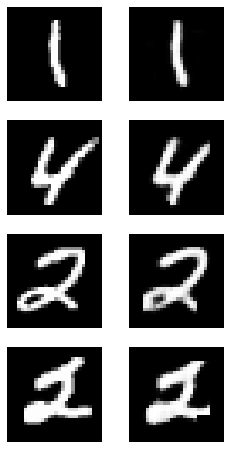

313/313 [==============================] - 1s 3ms/step - loss: 0.0073


0.007301750127226114

In [ ]:
# 9.10 test 데이터로 컨볼루션 오토인코더의 이미지 재생성
import random

plt.figure(figsize=(4,8))
for c in range(4):
    plt.subplot(4, 2, c*2+1)
    rand_index = random.randint(0, test_X.shape[0])
    plt.imshow(test_X[rand_index].reshape(28, 28), cmap='gray')
    plt.axis('off')
    
    plt.subplot(4, 2, c*2+2)
    img = model.predict(np.expand_dims(test_X[rand_index], axis=0))
    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.axis('off')
    
plt.show()

model.evaluate(test_X, test_X)

출력 이미지에서 이전의 각진 모습은 거의 없고 loss는 훈련 데이터와 마찬가지로 낮게 나온다. 활성화 함수 하나를 바꿨을 때 이렇게 큰 차이가 나기때문에 딥러닝에서 활성화함수 선택을 비롯한 하이퍼파라미터의 선택은 매우 중요하다고 할 수 있다.

오토인코더는 노이즈를 제거하는 효과도 얻을 수 있다.

# 9.3 클러스터링

잠재변수는 데이터의 가장 압축된 표현이다. 정보의 일부르 읽어버리는 손실 압축을 거치지만 이전 절에서 본 것처럼 잃어버리는 정보는 이미지에 실수로 찍힌 작은 점처럼 중요하지 않거나 세부적인 것일 확률이 높다. 잠재변수에는 데이터를 효과적으로 복원할수 있도록 중요한 정보만 포함된다.       
이러한 잠재변수를 이용해 데이터를 여러 개의 군집으로 클러스터링(clustering)할 수 있다. 클러스터링은 원래 비지도학습의 한 종류이다. 이번 장의 첫 부분에서 입력에 대한 출력을 학습하는 지도학급에 대해 설명했다      
지도학습과는 달리 비지도학습은 입력에 대한 정답 출력이 존재하지 않는다. 앱에 접속하는 고객은 몇개의 집단으로 분류할 수 있을까? 사람의 얼굴이미지를 몇개의 집단으로 분류하는 것이 적절할까? 단편소설의 장르를 몇개로 구분할까?      
쉽게 답을 내리기 어려운 문제들이지만 클러스터링 알고리즘을 이용해 군집으로 나누는 시도를 해 볼 수 있다.

## 9.3.1 k평균 클러스터링

k평균 클러스터링은 주어진 입력 중 k 개의 크러스터 중심을 임의로 정한 다음에 각 데이터와 k 개의 중심과 거리를 비교해서 가장 가까운 클러스터로 배당하고 k개의 중심의 위치를 해당클러스터로 옮기는 것을 반복하는 간단한 알고리즘이다

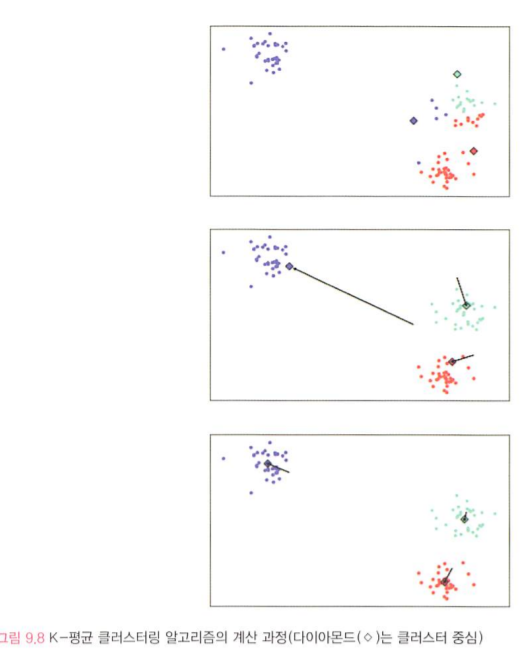

3차원 이상의 다차원 데이터에서도 k평균 클러스터링을 적용해볼 수 있다. 이전 절에서 사용했던 mnist데이터세트에서, 잠재변수는 64차원 이었다.      
 먼저 잠재변수를 분리할 수 있는 모델을 만든다. 좋은 결과를 보였던 예제 9.9 모델의 가중치를 그대로 재사용하는 다른 모델을 8장애 등장했던 함수형 API를 이용해서 만든다. 입력은 model의 입력을 그대로 사용하고 출력은 4번째 레이어(3번째 인덱스)의 Dense레이어의 출력을 사용한다.

In [ ]:
# 9.11 잠재변수 추출 모델 정의 및 실행
latent_vector_model = tf.keras.Model(inputs=model.input, outputs=model.layers[3].output)
latent_vector = latent_vector_model.predict(train_X)
print(latent_vector.shape)
print(latent_vector[0])

(60000, 64)
[26.810417   -1.         18.345846   21.536766   21.418442   -1.
 14.448879    7.629593   11.1034     -0.9999994  20.364548   22.326998
 -0.99969095 -0.99999994 -0.9999999   9.72186    -0.9999999  -1.
 16.325727   15.078174   -1.          3.150932    5.530719   24.283003
 -1.         18.404402   -0.99999994  9.345362   -1.          1.9669386
 -1.         22.706663   -0.9999997  -1.         15.189984   19.83681
 -0.99999994 -0.99999994 -1.         -1.         22.479824   18.768728
 21.213379    5.2171993   4.994567   -0.9999996  17.500032   -1.
  4.5157433   2.210046   -1.         13.467025   15.677101   -0.99999976
 -0.9999998  17.501865   -1.         21.317244   -0.99999976 10.905683
 -1.         26.578518   26.3849     15.477082  ]


한줄로 모델을 만들고 훈련데이터를 64차원의 잠재변수로 만들었다. 이제 이 잠재변수에 k 평균 클러스터링 알고리즘을 사용해 클러스터링을 시도한다. 이때 편리하게 k 평균 알고르짐을 불러올 수 있는 나이킷런 라이브러리를 사용할 수 있다.

In [ ]:
# 9.12 사이킷 런의 K-평균 클러스터링 알고리즘 사용
%%time
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, n_init=10, random_state=42)
kmeans.fit(latent_vector)

CPU times: user 18.1 s, sys: 3.24 s, total: 21.3 s
Wall time: 18 s


셀의 가장 첫 부분에는 노트북에 포함돼 있는 명령어인 %%time을 사용해 셀의 수행시간을 측정할 수 있게 했고, wall time은 실제로 걸린 시간을 의미하며, CPU time을 따로 표시하는 이유는 멀티코어를 사용할 경우 모든 코어의 계산시간을 합쳐서 표시하기 때문이다. 싱글코어의 경우 wall time 과 CPU time은 거의 비슷하게 나온다.

먼저 kMean() 함수로 k 평균 클러스터링 알고리즘을 계산할 객체를 초기화 한다. 인수 중에 n_clusters는 k에 해당하는 클러스ㅡ터 중심의 개수이다 . 여기서 mnist의 라벨 수와 같은 10을 선택 했다. n_init은 알고리즘의 실행 횟수로 여기서는 10을 입력했기 때문에 중심의 위치를 다르게 선택해서 10번 테스트한 뒤 가장 좋은 결과를 저장한다. random_state는 알고리즘의 계산 결과를 동일하게 가져가기 위해 지정하는 랜덤 초기화 숫자(random seed)이다.     
tf.keras처럼 fit()함수를 사용해 앞에서 계산한 잠재변수로 알고리즘을 학습시킨다. 이 밖에도 predict()함수 등 tf.keras와 사이킷런 사이에는 비슷한 문법이 꽤 있다.      
계산결과를 확인하기위해 kmeans변수에 저장된 lavels_와 cluster_ centers_를 출력해보겠다.

In [ ]:
# 9.13 계산 결과 확인
print(kmeans.labels_)
print(kmeans.cluster_centers_.shape)
print(kmeans.cluster_centers_[0])

[1 7 9 ... 1 2 5]
(10, 64)
[22.549135   -1.         15.056265   23.568913   15.830404   -0.99999994
 19.896261   15.051591   10.663937   -0.99999976  9.614452   17.992184
 -0.9957163  -0.9999998  -0.99999917 19.31446    -0.99999994 -0.9999998
 15.937633   21.840694   -1.         17.528646    6.042504   21.847786
 -0.99999994 11.964045   -0.99999994 14.24811    -1.         24.894684
 -0.99999994 19.34024    -0.9999986  -0.99999994 14.1626835  15.157345
 -0.9999998  -0.99999994 -0.9999999  -0.99999994 24.632055   12.932403
 14.785126   17.389587    3.5652876  -0.99999946 15.603172   -1.
 20.702065    5.9207397  -1.         15.777399   17.574038   -0.9999998
 -0.99999976 27.945026   -0.9999999  17.730152   -0.99999994 14.858133
 -1.         20.8403     18.734068   16.138542  ]


labels_에는 각 데이터가 0부터 9 사이의 어떤 클러스터에 속하는지에 대한 정보가 저장된다. cluster_centers_ 에는 각 클러스터의 중심 좌표가 저장되지만 잠재변수와 마찬가지로 64차원이기 때문에 이 좌표가 무엇을 의미하는지 직관적으로 알기도 힘들고 시각화하기도 어렵다.     
각 클러스터에 속하는 이미지가 어떤 것인지 출력해 보겠다

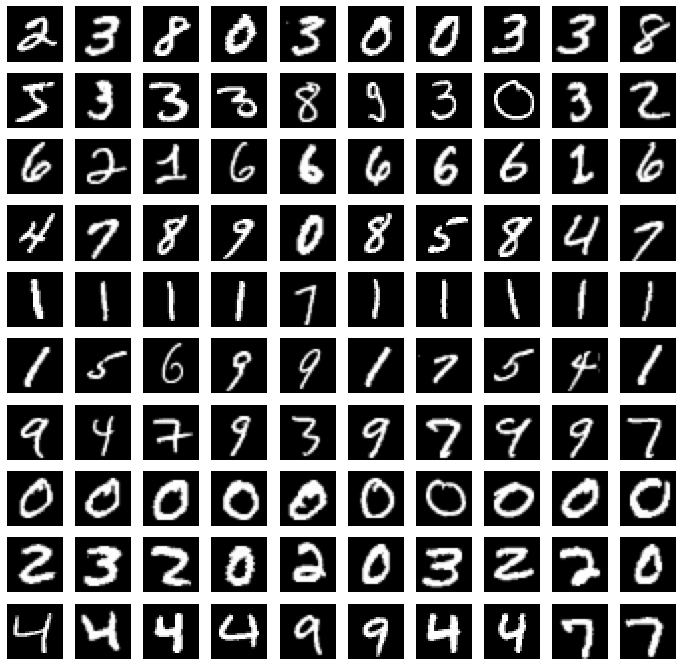

In [ ]:
# 9.14 클러스터링 결과 출력
plt.figure(figsize=(12,12))

for i in range(10):
    images = train_X[kmeans.labels_ == i]
    for c in range(10):
        plt.subplot(10, 10, i*10+c+1)
        plt.imshow(images[c].reshape(28,28), cmap='gray')
        plt.axis('off')
        
plt.show()